In [23]:
import pandas as pd
import numpy as np
import ast
import spacy
from sklearn.linear_model import LogisticRegression
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot  as plt
import seaborn as sns
import re
from tqdm import tqdm
import openai
from gensim.models import KeyedVectors
from typing import Tuple, List
from joblib import Parallel, delayed

In [2]:
df = pd.read_csv('Embeddings.csv')

In [24]:
def convert_embedding(x):
    if isinstance(x, str):
        x_clean = x.strip("[]")
        return np.fromstring(x_clean, sep=' ')
    return x

df['Sentence_Average_Embeddings'] = df['Sentence_Average_Embeddings'].apply(convert_embedding)

df['Embeddings'] = df['Embeddings'].apply(
    lambda x: [x[0].tolist()] if isinstance(x, list) and len(x) > 0 and isinstance(x[0], np.ndarray) else x
)

In [26]:
df = df.sample(frac=1).reset_index(drop=True)
df

,Image,Description,Class,Description_processed,Sentence_Average_Embeddings,Embeddings
0,n07716358_11220.JPEG,Fried snacks arranged neatly with dipping sauce.,zucchini,fried snack arrange neatly with dip sauce,"[-0.119227819, -0.0373273566, -0.0236990787, 0...","[array([-2.57812500e-01, -1.27563477e-02, 8.9..."
1,n07716358_9042.JPEG,Sliced zucchini arranged on a cutting board.,zucchini,slice zucchini arrange on a cutting board,"[-0.0478413887, 0.0287272129, -0.00160725915, ...","[array([-0.00299072, -0.11816406, 0.09179688,..."
2,n07716358_4456.JPEG,Long green zucchini on white tiled surface.,zucchini,long green zucchini on white tiled surface,"[-0.09151786, 0.13964844, 0.04190499, 0.091692...","[array([-1.43554688e-01, 1.04492188e-01, -1.9..."
3,n07716358_13984.JPEG,Zucchini growing beside vibrant yellow flower.,zucchini,Zucchini grow beside vibrant yellow flower,"[-0.06217448, 0.05712891, -0.00675456, 0.14343...","[array([-2.29492188e-01, 3.32031250e-02, -1.1..."
4,n07718472_3346.JPEG,"Fresh vegetables: tomatoes, cucumber, zucchini...",cucumber,fresh vegetable tomato cucumber zucchini and b...,"[-0.107218422, 0.137471512, 0.126708984, 0.247...","[array([-0.04223633, 0.01806641, 0.22070312,..."
...,...,...,...,...,...,...
2355,n07716358_3785.JPEG,Man smiling while holding a large zucchini.,zucchini,man smile while hold a large zucchini,"[0.117553711, 0.0965576172, 0.0643310547, 0.10...","[array([ 0.32617188, 0.13085938, 0.03466797,..."
2356,n07716358_12903.JPEG,Sliced vegetables including cucumber and carro...,zucchini,slice vegetable include cucumber and carrot di...,"[-0.01490275, 0.08829752, 0.03326416, 0.161804...","[array([-0.00299072, -0.11816406, 0.09179688,..."
2357,n07716358_22588.JPEG,Fresh green zucchini on a white background.,zucchini,fresh green zucchini on a white background,"[0.01713053, 0.06762695, 0.0401001, 0.05361938...","[array([-0.04223633, 0.01806641, 0.22070312,..."
2358,n07718472_1821.JPEG,Two cucumbers displayed alongside a measuring ...,cucumber,two cucumber display alongside a measure tape,"[0.00699869776, 0.11831665, -0.0138600664, 0.0...","[array([ 0.03173828, -0.10644531, 0.00241089,..."


# Train LR

In [27]:
X = np.stack(df['Sentence_Average_Embeddings'].values)
y = df['Class']

train_size = 2000
X_train = X[:train_size]
X_test = X[train_size+1:]
X_test_embeddings = df['Embeddings'][train_size+1:].reset_index(drop=True)

y_train = y[:train_size]
y_test = y[train_size+1:]

model = LogisticRegression()
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9192200557103064


In [28]:
def process_instance_lime(i, text, label):
    explained = explainer.explain_instance(text, predict_probabilities_from_text, num_features=15)
    lime_word_importances = explained.as_list()
    importances_df = pd.DataFrame(lime_word_importances, columns=["word", "importance"])
    importances_df["class"] = label
    importances_df["Description_processed"] = text
    importances_df['importance']=importances_df['importance'].abs()
    return importances_df

def process_instance_smer(i, text, label):
    # Original prediction for the full text
    original_pred = predict_probabilities_from_text([text])[0]
    original_class = np.argmax(original_pred)  # Determine predicted class
    importance_rows = []

    # Split the text into words
    words = text.split()

    # Iteratively remove each word and measure the impact on the probability
    for word in words:
        altered_text = ' '.join(w for w in words if w != word)

        # Predict probability for the altered text
        if len(altered_text.strip()) == 0:
            altered_pred = original_pred.copy()
        else:
            altered_pred = predict_probabilities_from_text([altered_text])[0]

        # Calculate the change in probability for the predicted class
        drop = original_pred[original_class] - altered_pred[original_class]

        importance_row = {
            "word": word,
            "importance": abs(drop),  # Absolute value of the drop
            "class": label,
            "Description_processed": text,
            "original_probability": original_pred[original_class]
        }
        importance_rows.append(importance_row)
    importances_df = pd.DataFrame(importance_rows)

    return importances_df


openai.api_key="API_KEY"
def predict_probabilities_from_text(texts):
    vectors = []
    for text in texts:
        # Split text into words
        words = text.split()
        if words:
            response = openai.Embedding.create(
                model="text-embedding-3-small",
                input=words
            )
            word_embeddings = [np.array(item["embedding"]) for item in response["data"]]
            vector = np.mean(word_embeddings, axis=0)
            vectors.append(vector)
        else:
            vectors.append(np.zeros(1534))

    # Convert list of vectors to a 2D numpy array
    vectors = np.vstack(vectors)
    return model.predict_proba(vectors)

def remove_words(text, words_to_remove):
    return ' '.join([word for word in text.split() if word not in words_to_remove])


def compute_AOPC_custom(df, top_words, max_K=6):
    avg_drops = []
    for K in range(0, max_K + 1):
        drops = []
        for idx, row in df.iterrows():
            text = row["Description_processed"]
            original_pred = predict_probabilities_from_text([text])[0]
            original_class = np.argmax(original_pred)
            original_prob = original_pred[original_class]

            words_in_text = text.split()
            top_words_in_text = [word for word in top_words if word in words_in_text]
            num_words_to_remove = min(K, len(top_words_in_text))
            words_to_remove = top_words_in_text[:num_words_to_remove]
            altered_text = remove_words(text, words_to_remove)

            # If no change in the text, the drop is zero
            if text == altered_text:
                drop = 0
            else:
                altered_pred = predict_probabilities_from_text([altered_text])[0]
                altered_prob = altered_pred[original_class]
                drop = original_prob - altered_prob

            drops.append(drop)
        avg_drop = np.mean(drops)
        avg_drops.append(avg_drop)

    return avg_drops

In [ ]:
lime_df = pd.DataFrame(columns=["word", "importance", "class"])
# Initialize the LIME text explainer
explainer = LimeTextExplainer(class_names=['cucumber', 'vase'], random_state=42)
test_df = df

results = Parallel(n_jobs=-1)(delayed(process_instance_lime)(i, text, label) for i, (text, label) in enumerate(tqdm(zip(test_df["Description_processed"], test_df["Class"]))))

lime_df = pd.concat(results).reset_index(drop=True)
lime_df.to_csv('lime_df_C_Z.csv', index=False)

In [ ]:
results_smer = Parallel(n_jobs=-1)(
    delayed(process_instance_smer)(i, text, label)
    for i, (text, label) in enumerate(tqdm(zip(test_df["Description_processed"], test_df["Class"])))
)
smer_df = pd.concat(results_smer, ignore_index=True)
smer_df.to_csv("smer_df_C_Z.csv", index=False)

In [43]:
global_importances_lime = lime_df.groupby('word')['importance'].mean().reset_index()
global_importances_smer = smer_df.groupby('word')['importance'].mean().reset_index()

ranked_words_global_lime = global_importances_lime.sort_values(by='importance', ascending=False)['word'].tolist()
ranked_words_global_smer = global_importances_smer.sort_values(by='importance', ascending=False)['word'].tolist()

top_10_words_lime = ranked_words_global_lime[:10]
top_10_words_smer = ranked_words_global_smer[:10]

AOPC_LIME = compute_AOPC_custom(test_df, top_10_words_lime, max_K=6)
AOPC_SMER = compute_AOPC_custom(test_df, top_10_words_smer, max_K=6)

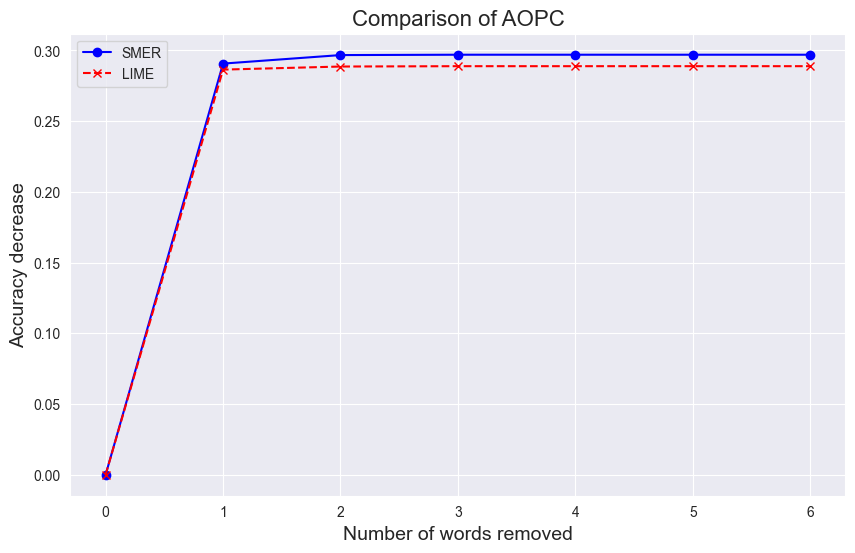

In [48]:
plt.figure(figsize=(10, 6))
plt.plot (AOPC_SMER, marker='o', linestyle='-', color='b', label='SMER')
plt.plot(AOPC_LIME, marker='x', linestyle='--', color='r', label='LIME')
plt.xlabel('Number of words removed', fontsize=14)
plt.ylabel('Accuracy decrease', fontsize=14)
plt.title('Comparison of AOPC',fontsize=16)
plt.grid(True)
plt.legend()
plt.show()